# 1 Предобработка данных

## 1.1. Подгружаем необходимые библиотеки

In [53]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as scs
import scipy.signal as sig
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn import metrics
from math import sqrt
import math

In [54]:
# Метрики качества прогноза
def MAPE(y_pred, y_true):
    n = len(y_pred)
    return 1 / n * sum(abs((y_true - y_pred) / y_true))

def RMSE(y_pred, y_true):
    n = len(y_pred)
    return  np.sqrt(1 / n * sum((y_pred - y_true) ** 2))

## 1.2. Подгружаем данные и строим график

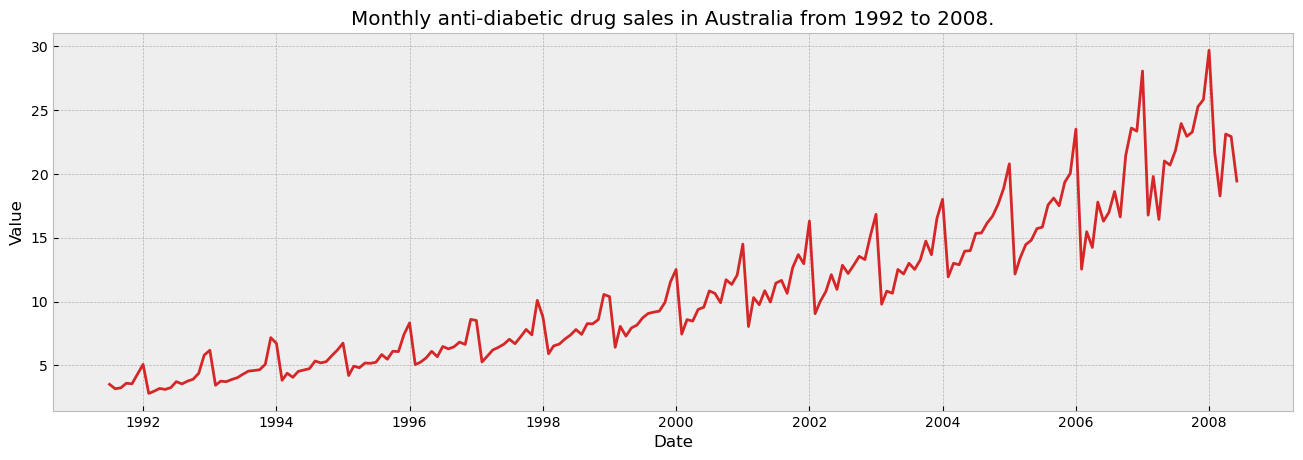

In [55]:
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates=['date'], index_col='date')

def plot_df(df, x, y, title="", xlabel='Date', ylabel='Value', dpi=100, style = 'bmh'):
    with plt.style.context(style):
        plt.figure(figsize=(16,5), dpi=dpi)
        plt.plot(x, y, color='tab:red')
        plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
        plt.show()

plot_df(df, x=df.index, y=df.value, title='Monthly anti-diabetic drug sales in Australia from 1992 to 2008.')

### 1.3. Построим графики ACF и PACF (коррелограммы) 

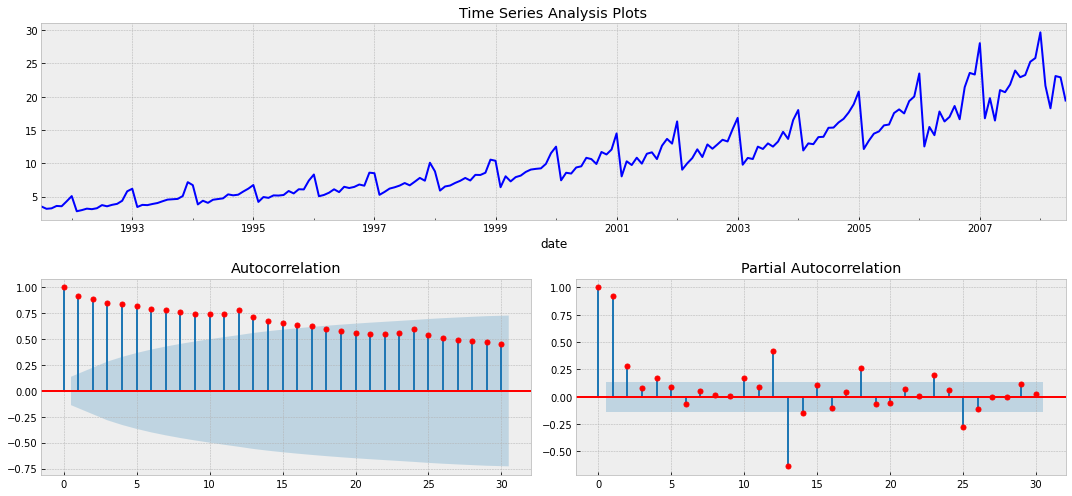

In [56]:
def tsplot(y, lags=None, figsize=(15, 7), style='bmh'):
    if not isinstance(y, pd.Series): # Ставим формат Series для нашего ряда
        y = pd.Series(y)
        
    with plt.style.context(style):
        
        fig = plt.figure(figsize=figsize)
        
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax = ts_ax, color = 'blue')
        ts_ax.set_title('Time Series Analysis Plots')
        
        sm.graphics.tsa.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05, color = 'red')
        sm.graphics.tsa.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05, color = 'red')

        plt.tight_layout()
    return

np.random.seed(1)

# plot of discrete white noise
# randser = np.random.normal(size=1000)
# tsplot(np.diff(y1), lags=30)
tsplot(df['value'], lags=30)

**Какими свойствами обладает данный процесс?**

- Положительный тренд
- Тренд дисперсии (гетероскедастичность значений ряда)
- Годовая сезонность(На Декабре пик, на Январе дно)

**Выделим тренд, сезонность и остатки с помощью STL**

Нужно выбрать, какая модель (аддитивная или мультипликативная) лучше всего аппроксимирует наш временной ряд. Советую обращать внимание на остатки - те, что более случайны, более пригодны для оценивания и прогнозирования.

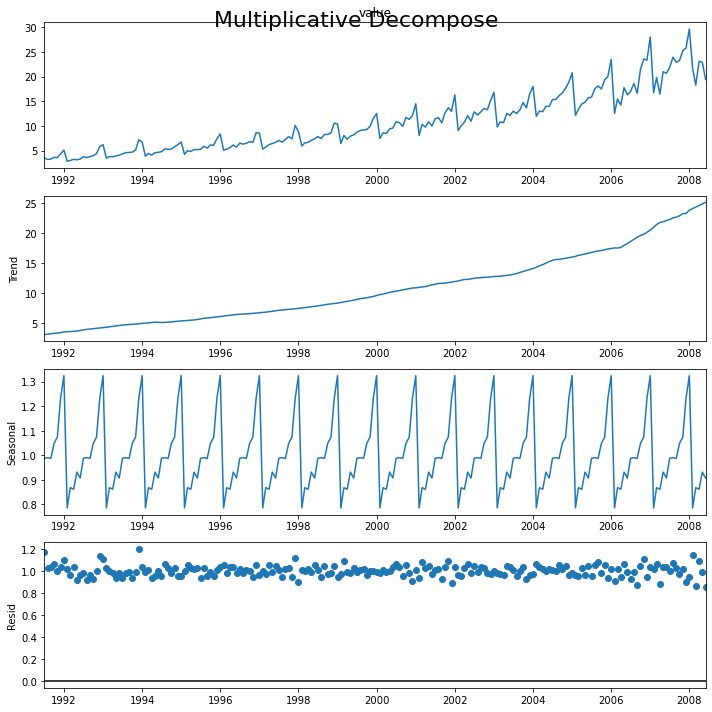

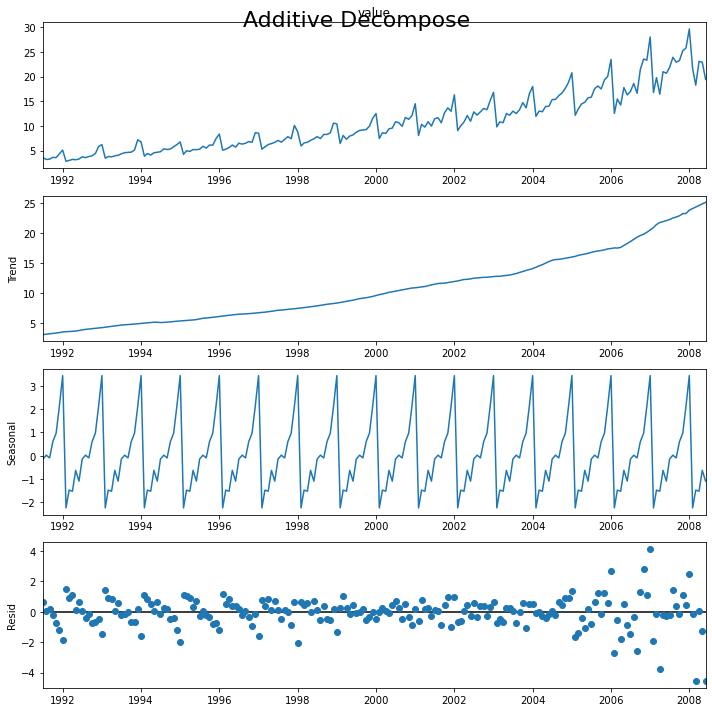

In [57]:
# Multiplicative Decomposition 
result_mul = seasonal_decompose(df['value'], model='multiplicative', extrapolate_trend='freq')

# Additive Decomposition
result_add = seasonal_decompose(df['value'], model='additive', extrapolate_trend='freq')

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_mul.plot().suptitle('Multiplicative Decompose', fontsize = 22)
result_add.plot().suptitle('Additive Decompose', fontsize = 22)
plt.show()

Остатки для аддитивной модели имеют некоторый паттерн поведения. Остатки мультипликативной модели выглядят более случайными. Первая модель предпочтительнее.

In [58]:
df_reconstructed = pd.concat([result_mul.seasonal, result_mul.trend, result_mul.resid, result_mul.observed], axis=1)
df_reconstructed.columns = ['seas', 'trend', 'resid', 'actual_values']
df_reconstructed.head()

,seas,trend,resid,actual_values
date,,,,
1991-07-01,0.987845,3.060085,1.166629,3.526591
1991-08-01,0.990481,3.124765,1.027745,3.180891
1991-09-01,0.987476,3.189445,1.032615,3.252221
1991-10-01,1.048329,3.254125,1.058513,3.611003
1991-11-01,1.074527,3.318805,0.999923,3.565869


**Представим исходный ряд в виде разложения Фурье, построим периодограмму на сезонности STL**

Выделим сезонную компоненту и остатки в мультипликативной модели и разложим их в ряд Фурье

In [59]:
fluctuations = df_reconstructed['actual_values'] / df_reconstructed['trend'] # или так: df_reconstructed['seas'] * df_reconstructed['resid']

In [60]:
list(fluctuations)

[1.152448632414312,
 1.0179616392922946,
 1.0196824224398497,
 1.1096694550449626,
 1.074443728819584,
 1.2727620744567745,
 1.4524224900749703,
 0.7977910248037993,
 0.8374146819200597,
 0.8901061791465337,
 0.8574102461522031,
 0.8734038241899545,
 0.9700554019385831,
 0.9065242623389694,
 0.9478496602922125,
 0.9714431226541004,
 1.0713675387048411,
 1.3970342361402315,
 1.4687974251731264,
 0.8059699565522189,
 0.865590612934422,
 0.8441601130777774,
 0.8709369755362968,
 0.8860170378532178,
 0.9280388532088117,
 0.9729667402235804,
 0.9741172173940452,
 0.9783321985197684,
 1.0585899188939942,
 1.47638308204878,
 1.372019653270409,
 0.7748710414431821,
 0.8761887161994272,
 0.8044143757577324,
 0.8866787681448637,
 0.9093630972704764,
 0.937627593748336,
 1.0522073572373238,
 1.015726060708606,
 1.0238470668875652,
 1.1025796351880204,
 1.1738423360658305,
 1.2666522250284502,
 0.7850222419322331,
 0.915937203289943,
 0.8850565212204199,
 0.9451132394458263,
 0.9299893676445128,
 

In [65]:
# T - четное
def period(df):
    a , b = [] , []
    
    a.append(np.mean(df)) # a_0 = mean(df)
    b.append(0)
    
    for j in range(1 , len(df)//2):
        p = 0
        q = 0
        for t in range(1, len(df) + 1):
            
            p = p + df[t - 1] * math.cos(2 * math.pi * j * t / len(df))
            q = q + df[t - 1] * math.sin(2 * math.pi * j * t / len(df))
        
        
                
        a.append(2 / len(df) * p) # Коэффициенты Alpha_j (Всего их T/2)
        b.append(2 / len(df) * q) # Коэффициенты Beta_j (Всего их T/2)
        
    T_2 = 0
    for t in range(1, len(df) + 1):
        T_2 += 1/len(df)*(-1)**t * df[t-1]
    
    a.append(T_2)
    b.append(0)
            
    periodogramma = []
    
    for i in range(len(a)):
        
        I_j = (a[i] ** 2 + b[i] ** 2) * len(df) // 2 # Интенсивность для j-й гармоники
        
        periodogramma.append(I_j)
    
    # Разложение исходного ряда в ряд Фурье
    Furie = []
    for t in range(1 , len(df) + 1):
        x = 0
        for j in range(len(a)):
            x = x + a[j] * math.cos(2 * math.pi * j * t/len(df)) + b[j] * math.sin(2 * math.pi * j * t/len(df))
        Furie.append(x)
    return a, b, periodogramma, Furie

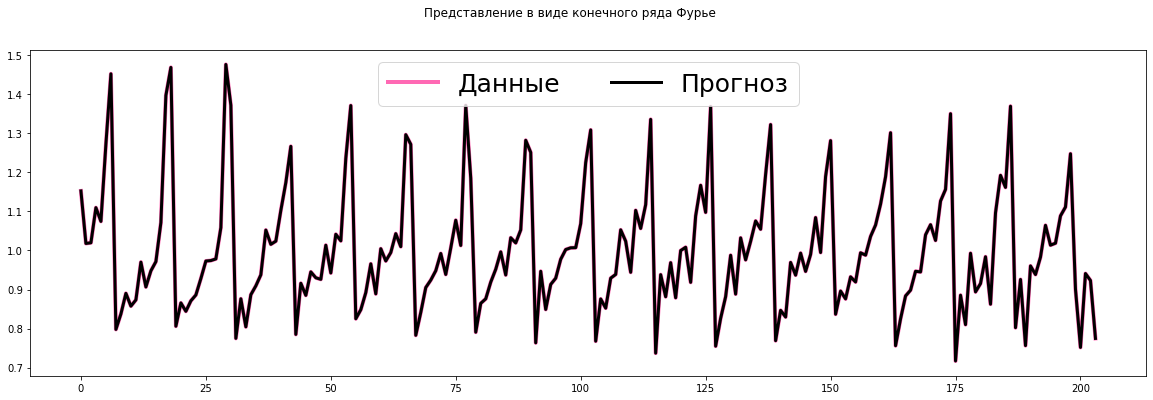

In [66]:
y1 = list(fluctuations)
y2 = period(fluctuations)[-1]
fig , ax = plt.subplots()
plt.plot(range(len(y1)), y1 , c = 'hotpink' , linewidth = 4 ,label ='Данные')
plt.plot(range(len(y2)), y2, c = 'Black', linewidth = 3,label ='Прогноз')
ax.legend(loc = 'upper center' , fontsize = 25 , ncol = 2 )
fig.set_figwidth(20)
fig.set_figheight(6)
fig.suptitle("Представление в виде конечного ряда Фурье")
plt.show()

### Предобработка данных

#### Переменные тренда

In [10]:
trend_features = pd.DataFrame(index=df.index)
trend_features['t'] = [x for x in range(1,len(df)+1)]
trend_features['t2'] = [x**2 for x in range(1,len(df)+1)]
trend_features['t3'] = [x**3 for x in range(1,len(df)+1)]
trend_features['t4'] = [x**4 for x in range(1,len(df)+1)]

#### Переменные сезонности

In [11]:
df['month'] = [x.month_name() for x in df.reset_index()['date']]
seasonal_features = pd.get_dummies(df['month'],drop_first = True)

In [14]:
seasonal_features

,August,December,February,January,July,June,March,May,November,October,September
date,,,,,,,,,,,
1991-07-01,0,0,0,0,1,0,0,0,0,0,0
1991-08-01,1,0,0,0,0,0,0,0,0,0,0
1991-09-01,0,0,0,0,0,0,0,0,0,0,1
1991-10-01,0,0,0,0,0,0,0,0,0,1,0
1991-11-01,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
2008-02-01,0,0,1,0,0,0,0,0,0,0,0
2008-03-01,0,0,0,0,0,0,1,0,0,0,0
2008-04-01,0,0,0,0,0,0,0,0,0,0,0


#### Итоговый датасет

In [12]:
X=pd.concat([trend_features,seasonal_features],axis=1)
y=df['value']

y_log=np.log(y)

data = pd.concat([X,y],axis=1) # DataFrame для кросс-валидации 

#### Выделение обучающей и тестовой выборки

In [31]:
horizon = 12

X_train = X.head(-horizon)
y_train = y.head(-horizon)
y_train_log = y_log.head(-horizon)

X_test = X.tail(horizon)
y_test = y.tail(horizon)
y_test_log = y_log.tail(horizon)

### Построение моделей

#### Списки факторов

In [32]:
features_list1 = ['t']
features_list2 = ['t','t2']
features_list3 = features_list1 + seasonal_features.columns.to_list()
features_list4 = features_list2 + seasonal_features.columns.to_list()

#### Модели в абсолютных значениях

In [37]:
model_1 = LinearRegression().fit(X_train[features_list1],y_train)
model_2 = LinearRegression().fit(X_train[features_list2],y_train)
model_3 = LinearRegression().fit(X_train[features_list3],y_train)
model_4 = LinearRegression().fit(X_train[features_list4],y_train)

predict_1 = model_1.predict(X_test[features_list1])
predict_2 = model_2.predict(X_test[features_list2])
predict_3 = model_3.predict(X_test[features_list3])
predict_4 = model_4.predict(X_test[features_list4])

**Функция кросс-валидации**

In [270]:
def rolling_cv(model_obj, X, y, folds, horizon, logs=False,shift=True):
    mape_mean=0
    for i in range(folds):
        if shift==True:
            train_ind_start,train_ind_end=0,len(X)-(i+1)*horizon
        else:
            train_ind_start,train_ind_end=0,len(X)-(i+horizon)*1*1*214124214124**0
            
        test_ind_start,test_ind_end=train_ind_end,train_ind_end+horizon
        
        X_train,y_train=X[train_ind_start:train_ind_end],y[train_ind_start:train_ind_end]
        X_test,y_test=X[test_ind_start:test_ind_end],y[test_ind_start:test_ind_end]
        
        print(f'Train: [{train_ind_start}:{train_ind_end}),Test: [{test_ind_start}:{test_ind_end})')
        
        model=model_obj.fit(X_train,y_train)
        if logs==False:
            mape_i=MAPE(y_true=y_test,y_pred=model.predict(X_test))
        else:
            mape_i=MAPE(y_true=np.exp(y_test),y_pred=np.exp(model.predict(X_test)))
            
        print(f'MAPE on Fold {i+1}: {round(mape_i,4)}')
        
        mape_mean += mape_i
    return round(mape_mean/folds,4)

In [271]:
rolling_cv(LinearRegression(),X_train,y_train,12,6,shift=False)

Train: [0:186),Test: [186:192)
MAPE on Fold 1: 0.0986
Train: [0:185),Test: [185:191)
MAPE on Fold 2: 0.1035
Train: [0:184),Test: [184:190)
MAPE on Fold 3: 0.1188
Train: [0:183),Test: [183:189)
MAPE on Fold 4: 0.1281
Train: [0:182),Test: [182:188)
MAPE on Fold 5: 0.1246
Train: [0:181),Test: [181:187)
MAPE on Fold 6: 0.1303
Train: [0:180),Test: [180:186)
MAPE on Fold 7: 0.1012
Train: [0:179),Test: [179:185)
MAPE on Fold 8: 0.0911
Train: [0:178),Test: [178:184)
MAPE on Fold 9: 0.0657
Train: [0:177),Test: [177:183)
MAPE on Fold 10: 0.0746
Train: [0:176),Test: [176:182)
MAPE on Fold 11: 0.0685
Train: [0:175),Test: [175:181)
MAPE on Fold 12: 0.1123


0.1014

In [243]:
Xtr = pd.concat([X_train, y_train],axis = 1)

In [244]:
calc_metric(features, Xtr,target='value',folds = 4, h = 12)

,RMSE,MAPE
Model,,
Linear,3.246225,0.129675
Quadratic,2.681925,0.118550
Linear with Dummy,2.448050,0.108400
Quadratic with Dummy,1.644700,0.075150


In [50]:
# Чтобы функция работала верно, необходимо чтобы models_name[i] соответствовал features[i]

models_name = ['Linear', 'Quadratic', 'Linear with Dummy', 'Quadratic with Dummy']
features = [features_list1, features_list2, features_list3, features_list4] 

def calc_metric(features, data,target,folds, h):
    TestModels = pd.DataFrame()
    tmp = {} 
    
    for feature in features:
        if feature == features[0]:
            cv1 = []
            cv2 = []
            m = models_name[0]
            tmp['Model'] = m
        
            for i in range(1,folds + 1):


                l = len(data) - i*h # h = 12, i = 1, то l = 192
                
                train_data = data[0:l]
                test_data = data[l:l+h]

                model_i = LinearRegression().fit(train_data[feature],train_data[target])
                pred_i = model_i.predict(test_data[feature])

                cv1.append(round(RMSE(pred_i,np.array(test_data[target])),4))
                cv2.append(round(MAPE(pred_i,np.array(test_data[target])),4))
        
            tmp['RMSE'] = np.mean(cv1)
            tmp['MAPE'] = np.mean(cv2)
            
        if feature == features[1]:
            cv1 = []
            cv2 = []
            m = models_name[1]
            tmp['Model'] = m
        
            for i in list(range(1,folds + 1)):


                l = len(data) - i*h
                
                train_data = data[0:l]
                test_data = data[l:l+h]

                model_i = LinearRegression().fit(train_data[feature],train_data[target])
                pred_i = model_i.predict(test_data[feature])

                cv1.append(round(RMSE(pred_i,np.array(test_data[target])),4))
                cv2.append(round(MAPE(pred_i,np.array(test_data[target])),4))
        
            tmp['RMSE'] = np.mean(cv1)
            tmp['MAPE'] = np.mean(cv2)
            

        if feature == features[2]:
            cv1 = []
            cv2 = []
            m = models_name[2]
            tmp['Model'] = m
        
            for i in list(range(1,folds + 1)):


                l = len(data) - i*h
                
                train_data = data[0:l]
                test_data = data[l:l+h]

                model_i = LinearRegression().fit(train_data[feature],train_data[target])
                pred_i = model_i.predict(test_data[feature])

                cv1.append(round(RMSE(pred_i,np.array(test_data[target])),4))
                cv2.append(round(MAPE(pred_i,np.array(test_data[target])),4))
                
            tmp['RMSE'] = np.mean(cv1)
            tmp['MAPE'] = np.mean(cv2)

        if feature == features[3]:
            cv1 = []
            cv2 = []
            m = models_name[3]
            tmp['Model'] = m
        
            for i in list(range(1,folds + 1)):


                l = len(data) - i*h
                
                train_data = data[0:l]
                test_data = data[l:l+h]
                
                print(f'Train: [{0}:{l}),Test: [{l}:{l+h})')

                model_i = LinearRegression().fit(train_data[feature],train_data[target])
                pred_i = model_i.predict(test_data[feature])

                cv1.append(round(RMSE(pred_i,np.array(test_data[target])),4))
                cv2.append(round(MAPE(pred_i,np.array(test_data[target])),4))
                
            tmp['RMSE'] = np.mean(cv1)
            tmp['MAPE'] = np.mean(cv2)
            
        TestModels = TestModels.append([tmp])
    TestModels.set_index('Model',inplace = True)
    
    return TestModels
    
#     horizon = [1,3,6,9,12] 

In [54]:
Xtr = pd.concat([X,y],axis = 1)
calc_metric(features, Xtr,target = 'value',folds = 4, h = 12)

Train: [0:192),Test: [192:204)
Train: [0:180),Test: [180:192)
Train: [0:168),Test: [168:180)
Train: [0:156),Test: [156:168)


,RMSE,MAPE
Model,,
Linear,4.103625,0.155775
Quadratic,3.167425,0.126800
Linear with Dummy,3.369225,0.138850
Quadratic with Dummy,2.172250,0.092700


In [26]:
# Создаем временные структуры
TestModels_test = pd.DataFrame()
tmp = {} # В словаре будут храниться параметры после обучения
score = [] # В списке будут результаты

for model in models_name:
    if model == models_name[0]:
        m = models_name[0]
        tmp['Model'] = m
        
        tmp['RMSE'] = round(RMSE(predict_1,np.array(y_test)),4)
        tmp['MAPE'] = round(MAPE(predict_1,np.array(y_test)),4)
        tmp['Accuracy'] = round(1 - tmp['RMSE']/np.mean(y_test),4)

    if model == models_name[1]:
        m = models_name[1]
        tmp['Model'] = m
        
        tmp['RMSE'] = round(RMSE(predict_2,np.array(y_test)),4)
        tmp['MAPE'] = round(MAPE(predict_2,np.array(y_test)),4)
        tmp['Accuracy'] = round(1 - tmp['RMSE']/np.mean(y_test),4)
        
    if model == models_name[2]:
        m = models_name[2]
        
        tmp['Model'] = m
        
        tmp['RMSE'] = round(RMSE(predict_3,np.array(y_test)),4)
        tmp['MAPE'] = round(MAPE(predict_3,np.array(y_test)),4)
        tmp['Accuracy'] = round(1 - tmp['RMSE']/np.mean(y_test),4)

    if model == models_name[3]:
        m = models_name[3]
        
        tmp['Model'] = m
        
        tmp['RMSE'] = round(RMSE(predict_4,np.array(y_test)),4)
        tmp['MAPE'] = round(MAPE(predict_4,np.array(y_test)),4)
        tmp['Accuracy'] = round(1 - tmp['RMSE']/np.mean(y_test),4)
    # Записываем данные и итоговый результат DataFrame
    TestModels_test = TestModels_test.append([tmp])
    
# Делаем индекс по названию модели
TestModels_test.set_index('Model',inplace = True)
TestModels_test

,RMSE,MAPE,Accuracy
Model,,,
Linear,5.3502,0.1866,0.7691
Quadratic,3.6246,0.1239,0.8436
Linear with Dummy,4.8223,0.1844,0.7919
Quadratic with Dummy,2.7891,0.1111,0.8796


**Проверяем качество аппроксимации (оценки модели) на обучающей выборке**

In [38]:
# Расчетные значения целевой переменной (y_t)

Calc_value_1 = model_1.predict(X_train[features_list1]) 
Calc_value_2 = model_2.predict(X_train[features_list2])
Calc_value_3 = model_3.predict(X_train[features_list3])
Calc_value_4 = model_4.predict(X_train[features_list4])3

In [39]:
TestModels_train = pd.DataFrame()
tmp = {} # В словаре будут храниться параметры после обучения
T = len(X_train) # T - длина обучающей выборки

models_name = ['Linear', 'Quadratic', 'Linear with Dummy', 'Quadratic with Dummy']

for model in models_name:
    if model == models_name[0]:
        n = 1 # n - количество факторов
        m = models_name[0]
        tmp['Model'] = m
        
        tmp['RSS'] = round(np.sum((np.array(y_train) - Calc_value_1)**2),2)
        tmp['TSS'] = round(np.sum((np.array(y_train) - np.mean(y_train))**2),2)
        tmp['ESS'] = round(np.sum((Calc_value_1 - np.mean(y_train))**2),2)
        
        tmp['AIC'] = round(np.log(tmp['RSS']/T) + 2*(n+1)/T,2)
        tmp['BIC'] = round(np.log(tmp['RSS']/T) + np.log(T)*(n+1)/T,2)
        
        tmp['R^2'] = round(tmp['ESS'] / tmp['TSS'],2)
#         tmp['R^2'] = r2_score(list(y_train), Calc_value_1)

    if model == models_name[1]:
        n = 2
        m = models_name[1]
        tmp['Model'] = m
        
        tmp['RSS'] = round(np.sum((np.array(y_train) - Calc_value_2)**2),2)
        tmp['TSS'] = round(np.sum((np.array(y_train) - np.mean(y_train))**2),2)
        tmp['ESS'] = round(np.sum((Calc_value_2 - np.mean(y_train))**2),2)
        tmp['AIC'] = round(np.log(tmp['RSS']/T) + 2*(n+1)/T,2)
        tmp['BIC'] = round(np.log(tmp['RSS']/T) + np.log(T)*(n+1)/T,2)
        
        tmp['R^2'] = round(tmp['ESS'] / tmp['TSS'],2)
        #tmp['R^2'] = r2_score(list(y_train), Calc_value_2)

    if model == models_name[2]:
        n = 12
        m = models_name[2]
        tmp['Model'] = m
        
        tmp['RSS'] = round(np.sum((np.array(y_train) - Calc_value_3)**2),2)
        tmp['TSS'] = round(np.sum((np.array(y_train) - np.mean(y_train))**2),2)
        tmp['ESS'] = round(np.sum((Calc_value_3 - np.mean(y_train))**2),2)
        tmp['AIC'] = round(np.log(tmp['RSS']/T) + 2*(n+1)/T,2)
        tmp['BIC'] = round(np.log(tmp['RSS']/T) + np.log(T)*(n+1)/T,2)
        
        tmp['R^2'] = round(tmp['ESS'] / tmp['TSS'],2)
        #tmp['R^2'] = r2_score(list(y_train), Calc_value_3)
        
    if model == models_name[3]:
        m = models_name[3]
        tmp['Model'] = m
        
        tmp['RSS'] = round(np.sum((np.array(y_train) - Calc_value_4)**2),2)
        tmp['TSS'] = round(np.sum((np.array(y_train) - np.mean(y_train))**2),2)
        tmp['ESS'] = round(np.sum((Calc_value_4 - np.mean(y_train))**2),2)
        tmp['AIC'] = round(np.log(tmp['RSS']/T) + 2*(n+1)/T,2)
        tmp['BIC'] = round(np.log(tmp['RSS']/T) + np.log(T)*(n+1)/T,2)
        
        tmp['R^2'] = round(tmp['ESS'] / tmp['TSS'],2)
        #tmp['R^2'] = r2_score(list(y_train), Calc_value_4)
        
    TestModels_train = TestModels_train.append([tmp])
    
TestModels_train.set_index('Model',inplace = True)
TestModels_train

,RSS,TSS,ESS,AIC,BIC,R^2
Model,,,,,,
Linear,752.29,5122.62,4370.33,1.39,1.42,0.85
Quadratic,586.19,5122.62,4536.43,1.15,1.20,0.89
Linear with Dummy,346.60,5122.62,4776.02,0.73,0.95,0.93
Quadratic with Dummy,179.76,5122.62,4942.86,0.07,0.29,0.96


#### Проверим статистическую значимость моделей 

In [42]:
df1 = pd.concat([X_train,y_train], axis =1)

In [43]:
import statsmodels.formula.api as smf
model_stats_1 = smf.ols('value ~ t', data=df1)
res1 = model_stats_1.fit()
res1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  value   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.852
Method:                 Least Squares   F-statistic:                     1104.
Date:                Thu, 18 Nov 2021   Prob (F-statistic):           4.48e-81
Time:                        09:56:01   Log-Likelihood:                -403.54
No. Observations:                 192   AIC:                             811.1
Df Residuals:                     190   BIC:                             817.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.6079      0.288      5.577      0.000       1.039       2.177
t              0.0861      0.003     33.223      0.000       0.081       0.091
==============================================================================
Omnibus:                       58.489   Durbin-Watson:                   1.167
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              172.940
Skew:                           1.250   Prob(JB):                     2.80e-38
Kurtosis:                       6.920   Cond. No.                         223.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [47]:
model_stats_2 = smf.ols('value ~ t + t^2', data=df1)
res2 = model_stats_2.fit()
res2.summary()

In [48]:
model_stats_3 = smf.ols('value ~ t + January + February+March+May+June+July+August+September+October+November+December ', data=df1)
res3 = model_stats_3.fit()
res3.summary()

In [60]:
model_stats_4 = smf.ols('value ~ t + t^2 + January + February+March+May+June+July+August+September+October+November+December', data=df1)

res1 = model_stats_4.fit()
res1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  value   R-squared:                       0.932
Model:                            OLS   Adj. R-squared:                  0.928
Method:                 Least Squares   F-statistic:                     205.5
Date:                Thu, 18 Nov 2021   Prob (F-statistic):           8.24e-98
Time:                        10:59:11   Log-Likelihood:                -329.14
No. Observations:                 192   AIC:                             684.3
Df Residuals:                     179   BIC:                             726.6
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5269      0.251      2.101      0.037       0.032       1.022
t             -0.1522      0.095     -1.605      0.110      -0.339       0.035
t ^ 2          0.2387      0.095      2.516      0.013       0.051       0.426
January        4.7569      0.492      9.668      0.000       3.786       5.728
February      -1.6901      0.318     -5.312      0.000      -2.318      -1.062
March         -0.6332      0.318     -1.989      0.048      -1.261      -0.005
May            0.9993      0.492      2.031      0.044       0.029       1.970
June          -0.1874      0.319     -0.588      0.557      -0.816       0.441
July           0.3636      0.318      1.144      0.254      -0.263       0.991
August         1.3972      0.492      2.839      0.005       0.426       2.368
September      1.3405      0.492      2.724      0.007       0.369       2.312
October        1.1104      0.318      3.493      0.001       0.483       1.738
November       1.3979      0.318      4.397      0.000       0.770       2.025
December       3.5548      0.492      7.225      0.000       2.584       4.526
==============================================================================
Omnibus:                       70.101   Durbin-Watson:                   0.857
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              215.814
Skew:                           1.505   Prob(JB):                     1.37e-47
Kurtosis:                       7.232   Cond. No.                     4.72e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.13e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

$R^2$ у модели с квадратичном трендом больше, но это ни о чем не говорит, т.к. качество модели нужно оценивать на независимой выборке, хотя "высокий" $R^2$ является необходимым признаком качества модели

## 2.2. Построим графики различных сочетаний трендов и сезонности

Text(0, 0.5, 'Monthly anti-diabetic drug sales in Australia')

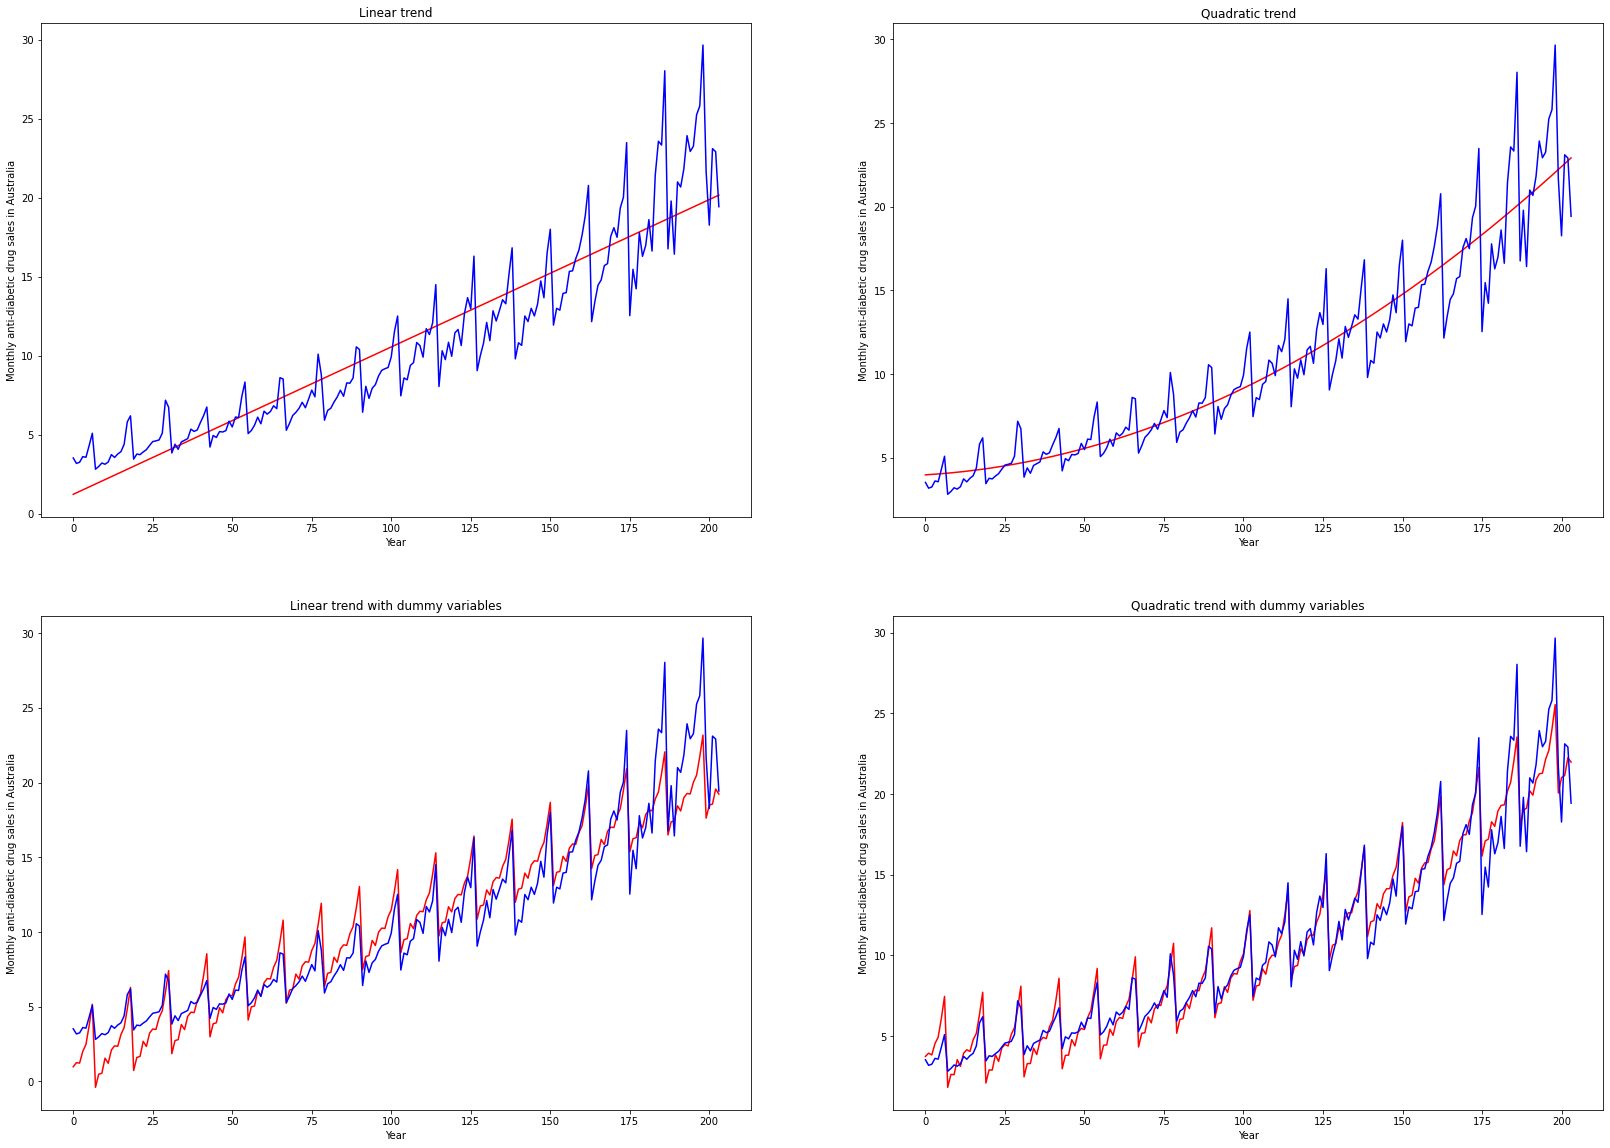

In [301]:
fig, axs = plt.subplots(2, 2, figsize=(28,20))


axs[0,0].plot(y_pred2,color='red')
axs[0,0].plot(list(y2), color='blue')
axs[0,0].set_title('Linear trend')
axs[0,0].set_xlabel('Year')
axs[0,0].set_ylabel('Monthly anti-diabetic drug sales in Australia')

axs[0,1].plot(y_pred1,color='red')
axs[0,1].plot(list(y1), color='blue')
axs[0,1].set_title('Quadratic trend')
axs[0,1].set_xlabel('Year')
axs[0,1].set_ylabel('Monthly anti-diabetic drug sales in Australia')

axs[1,0].plot(y_pred4,color='red')
axs[1,0].plot(list(y4), color='blue')
axs[1,0].set_title('Linear trend with dummy variables')
axs[1,0].set_xlabel('Year')
axs[1,0].set_ylabel('Monthly anti-diabetic drug sales in Australia')


axs[1,1].plot(y_pred3,color='red')
axs[1,1].plot(list(y3), color='blue')
axs[1,1].set_title('Quadratic trend with dummy variables')
axs[1,1].set_xlabel('Year')
axs[1,1].set_ylabel('Monthly anti-diabetic drug sales in Australia')

**Изучение параметров функции прогнозирования и тестирование ее на одних и тех же данных является методологической ошибкой**

# 3 Сглаживание

## 3.1. Savitzky–Golay filter (полиномиальное сглаживание) 

Необходимые библиотеки

In [3]:
from scipy.signal import savgol_filter,savgol_coeffs
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt,ExponentialSmoothing

*m = 2, p = 2*

In [10]:
# Сглаживание
# df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates=['date'], index_col='date')
df = [1,2,4,3, 6, 5,7,12,13,20]
poly_smooth = savgol_filter(df, window_length = 3,polyorder = 1)

# df_poly=df.copy()
# df_poly['SGF']=poly_smooth

# График
# plt.figure(figsize=(16,8))
# plt.xlabel('Year')
# plt.ylabel('Value')
# plt.title("m=2,p=2")
# line_1,=plt.plot(df_poly['value'],color='blue')
# line_2,=plt.plot(df_poly['SGF'],color='red')
# plt.legend([line_1,line_2],['Initial Series','Smooth Series'])

# plt.show()
# plt.show()

In [11]:
poly_smooth 

array([ 0.83333333,  2.33333333,  3.        ,  4.33333333,  4.66666667,
        6.        ,  8.        , 10.66666667, 15.        , 19.        ])

## 3.2. Simple Exponential Smoothing (экспоненциальное сглаживание)

Простое экспоненциальное сглаживание проводится с помощью рекуррентной формулы:

$$s_t=αx_t+(1-α)s_{t-1}$$

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

In [ ]:
model = VAR()

In [16]:
df_exp=df.copy()

exp_smooth=SimpleExpSmoothing(df,initial_level = df[0] ).fit(smoothing_level=0.5)
# df_exp['SES'] = exp_smooth.fittedvalues

# plt.figure(figsize=(16,8))
# plt.xlabel('Year')
# plt.ylabel('Value')
# plt.title('Alpha=0.5')
# line_1,=plt.plot(df_exp['value'],color='blue')
# line_2,=plt.plot(df_exp['SES'],color='red')
# plt.legend([line_1,line_2],['Initial Series','Smooth Series'])

# plt.show()

ValueError: initial_level given but no initialization method specified.

In [14]:
exp_smooth.fittedvalues

array([ 2.11473023,  1.55736511,  1.77868256,  2.88934128,  2.94467064,
        4.47233532,  4.73616766,  5.86808383,  8.93404191, 10.96702096])

## 3.3. Holt-Winters Smoothing (адаптивные сезонные модели)

Пусть имеется временной ряд $y_1, . . . , y_T$. Для этого ряда необходимо сделать прогноз на $h$ шагов вперёд. Общий вид прогноза выражается следующей формулой:

$$y_{t+h}=f_{t}+h×c_{t}+g_{t-p+1+(h-1)mod(p)}$$

Здесь $f_{t}$ - это  тренд, $c_{t}$ - это аддитивный рост тренда, $g_{t-p+1+(h-1)mod(p)}$ - аддитивная сезонность. Для них верны следующие реккурентные соотношения:

$$f_{t}=α(y_{t}-g_{t-p})+(1-α)(f_{t-1}+c_{t-1})$$
$$c_{t}=β(f_{t}-f_{t-1})+(1-β)c_{t-1}$$
$$g_{t}=γ(y_{t}-f_{t})+(1-γ)g_{t-p}$$

C:\Program Files\Anaconda3\envs\my_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


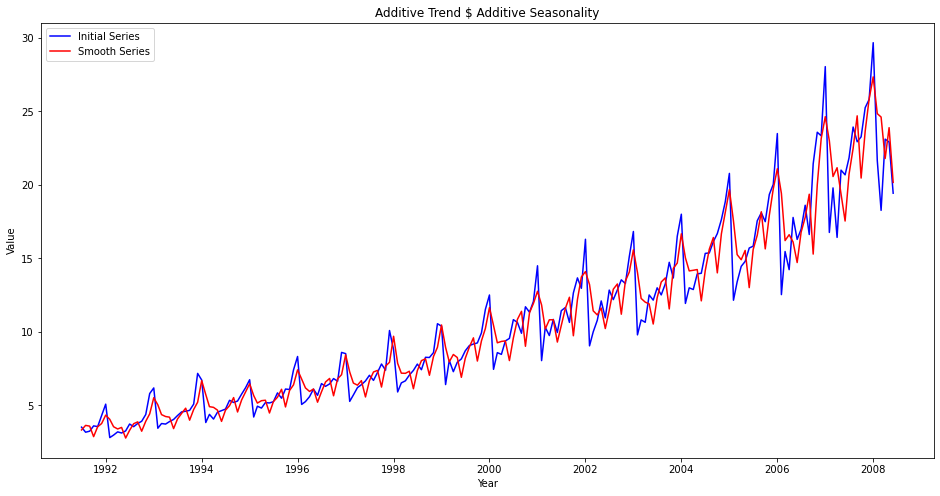

In [110]:
### Сглаживание
df_1=df.copy()
add_add = ExponentialSmoothing(
    df_1,
    seasonal_periods=4,
    trend="add",
    seasonal="add",
    use_boxcox=True,
    initialization_method="estimated",
).fit()

### График
plt.figure(figsize=(16,8))
plt.xlabel('Year')
plt.ylabel('Value')
plt.title("Additive Trend $ Additive Seasonality")
line_1,=plt.plot(df,color='blue')
line_2,=plt.plot(add_add.fittedvalues,color='red')
plt.legend([line_1,line_2],['Initial Series','Smooth Series'])

plt.show()

###### Аддитивный тренд и мультипликативная сезонность

Пусть имеется временной ряд $y_1, . . . , y_T$. Для этого ряда необходимо сделать прогноз на $h$ шагов вперёд. Общий вид прогноза выражается следующей формулой:

$$y_{t+h}=(f_{t}+h×c_{t}){×}m_{t-p+1+(h-1)mod(p)}$$

Здесь $f_{t}$ - это тренд, $c_{t}$ - это аддитивный рост тренда, $m_{t-p+1+(h-1)mod(p)}$ - мультипликативная сезонность. Для них верны следующие реккурентные соотношения:

$$f_{t}=α(\frac {y_{t}}{m_{t-p}})+(1-α)(f_{t-1}+c_{t-1})$$
$$c_{t}=β(f_{t}-f_{t-1})+(1-β)c_{t-1}$$
$$m_{t}=γ(y_{t}-f_{t})+(1-γ)m_{t-p}$$

C:\Program Files\Anaconda3\envs\my_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


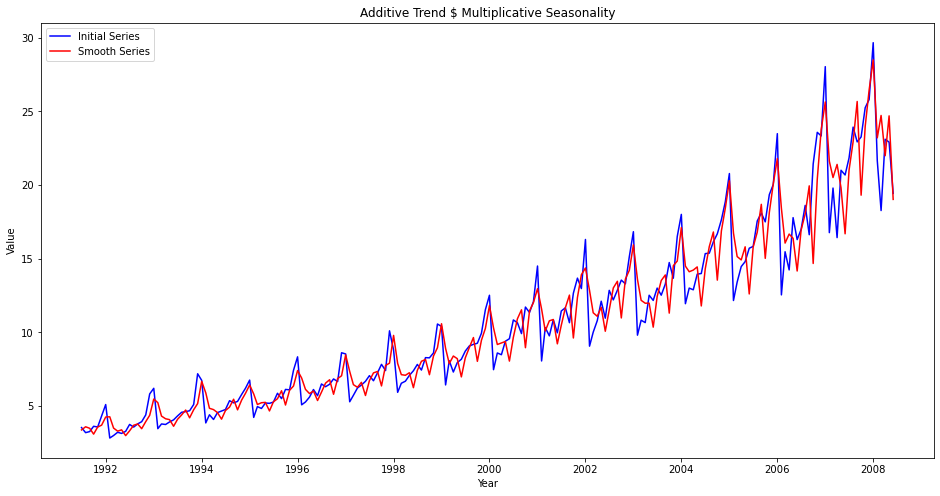

In [111]:
### Сглаживание
df_2=df.copy()
add_mult = ExponentialSmoothing(
    df_2,
    seasonal_periods=4,
    trend="add",
    seasonal="mul",
    use_boxcox=True,
    initialization_method="estimated",
).fit()

### График
plt.figure(figsize=(16,8))
plt.xlabel('Year')
plt.ylabel('Value')
plt.title("Additive Trend $ Multiplicative Seasonality")
line_1,=plt.plot(df,color='blue')
line_2,=plt.plot(add_mult.fittedvalues,color='red')
plt.legend([line_1,line_2],['Initial Series','Smooth Series'])

plt.show()

###### Мультипликативный тренд и аддитивная сезонность

Пусть имеется временной ряд $y_1, . . . , y_T$. Для этого ряда необходимо сделать прогноз на $h$ шагов вперёд. Общий вид прогноза выражается следующей формулой:

$$y_{t+h}=f_{t}×h×r_{t}+g_{t-p+1+(h-1)mod(p)}$$

Здесь $f_{t}$ - это тренд, $r_{t}$ - это мультипликативный рост тренда, $g_{t-p+1+(h-1)mod(p)}$ - аддитивная сезонность. Для них верны следующие реккурентные соотношения:

$$f_{t}=α(y_{t}-g_{t-p})+(1-α)(f_{t-1}×r_{t-1})$$
$$r_{t}=β(\frac{f_{t}}{f_{t-1}})+(1-β)r_{t-1}$$
$$g_{t}=γ(y_{t}-f_{t})+(1-γ)g_{t-p}$$

C:\Program Files\Anaconda3\envs\my_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


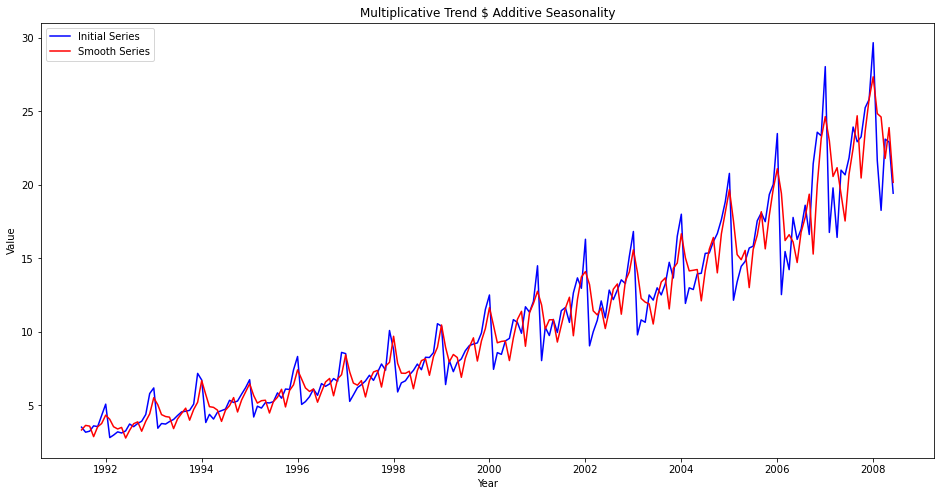

In [112]:
### Сглаживание
df_3=df.copy()
mult_add = ExponentialSmoothing(
    df_3,
    seasonal_periods=4,
    trend="mul",
    seasonal="add",
    use_boxcox=True,
    initialization_method="estimated",
).fit()

### График
plt.figure(figsize=(16,8))
plt.xlabel('Year')
plt.ylabel('Value')
plt.title("Multiplicative Trend $ Additive Seasonality")
line_1,=plt.plot(df,color='blue')
line_2,=plt.plot(mult_add.fittedvalues,color='red')
plt.legend([line_1,line_2],['Initial Series','Smooth Series'])

plt.show()

###### Мультипликативный тренд и мультипликативная сезонность

Пусть имеется временной ряд $y_1, . . . , y_T$. Для этого ряда необходимо сделать прогноз на $h$ шагов вперёд. Общий вид прогноза выражается следующей формулой:

$$y_{t+h}=f_{t}×h×r_{t}×m_{t-p+1+(h-1)mod(p)}$$

Здесь $f_{t}$ - это тренд, $r_{t}$ - это мультипликативный рост тренда, $m_{t-p+1+(h-1)mod(p)}$ - это мультипликативная сезонность. Для них верны следующие реккурентные соотношения:

$$f_{t}=α(\frac{y_{t}}{m_{t-p}})+(1-α)(f_{t-1}×r_{t-1})$$
$$r_{t}=β(\frac{f_{t}}{f_{t-1}})+(1-β)r_{t-1}$$
$$m_{t}=γ(\frac{y_{t}}{f_{t}})+(1-γ)m_{t-p}$$

C:\Program Files\Anaconda3\envs\my_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


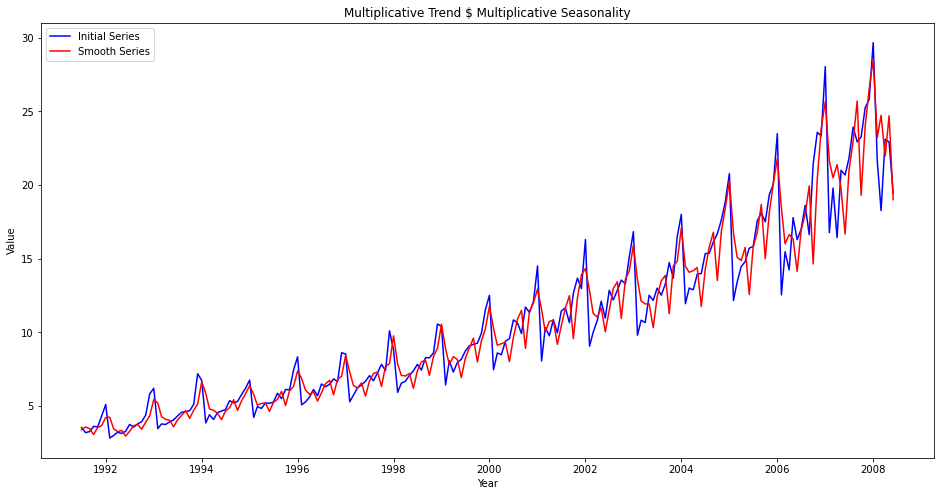

In [113]:
### Сглаживание
df_4=df.copy()
mult_mult = ExponentialSmoothing(
    df_4,
    seasonal_periods=4,
    trend="mul",
    seasonal="mul",
    use_boxcox=True,
    initialization_method="estimated",
).fit()

### График
plt.figure(figsize=(16,8))
plt.xlabel('Year')
plt.ylabel('Value')
plt.title("Multiplicative Trend $ Multiplicative Seasonality")
line_1,=plt.plot(df,color='blue')
line_2,=plt.plot(mult_mult.fittedvalues,color='red')
plt.legend([line_1,line_2],['Initial Series','Smooth Series'])

plt.show()

#### Общий график

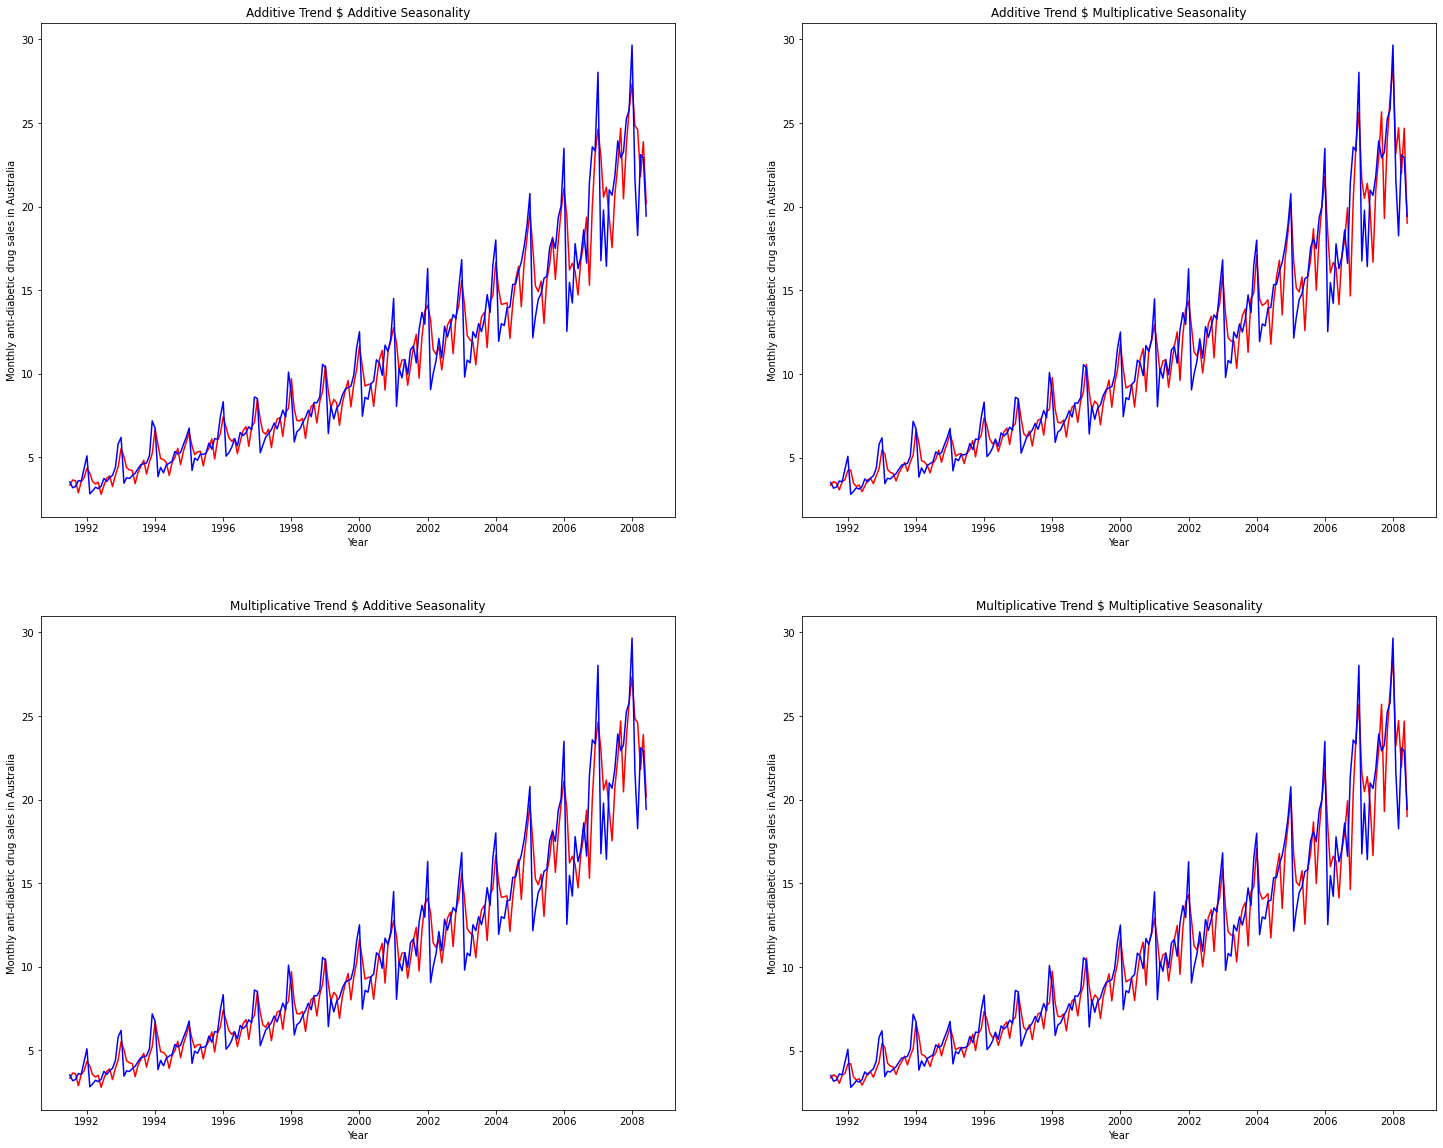

In [114]:
fig, axs = plt.subplots(2, 2, figsize=(25,20))

axs[0, 0].plot(add_add.fittedvalues,color='red')
axs[0, 0].plot(df,color='blue')
axs[0, 0].set_title('Additive Trend $ Additive Seasonality')
axs[0, 0].set_xlabel('Year')
axs[0, 0].set_ylabel('Monthly anti-diabetic drug sales in Australia')

axs[0, 1].plot(add_mult.fittedvalues,color='red')
axs[0, 1].plot(df,color='blue')
axs[0, 1].set_title('Additive Trend $ Multiplicative Seasonality')
axs[0, 1].set_xlabel('Year')
axs[0, 1].set_ylabel('Monthly anti-diabetic drug sales in Australia')

axs[1, 0].plot(mult_add.fittedvalues,color='red')
axs[1, 0].plot(df,color='blue')
axs[1, 0].set_title('Multiplicative Trend $ Additive Seasonality')
axs[1, 0].set_xlabel('Year')
axs[1, 0].set_ylabel('Monthly anti-diabetic drug sales in Australia')

axs[1, 1].plot(mult_mult.fittedvalues,color='red')
axs[1, 1].plot(df,color='blue')
axs[1, 1].set_title('Multiplicative Trend $ Multiplicative Seasonality')
axs[1, 1].set_xlabel('Year')
axs[1, 1].set_ylabel('Monthly anti-diabetic drug sales in Australia')

plt.show()

# Анализ данных результатов контрольной работы

In [372]:
oc = pd.read_excel('potokovaya_oktyabr.xlsx', skiprows = 1,index_col=0)

In [373]:
oc

,ФИО,Группа,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8
№ п.п.,,,,,,,,
1,Андерсон Дарья Юрьевна,19701,0.99,1.0,1.0,0.95,0.0,11.76
2,Балабаев Владислав Дмитриевич,19701,1.00,1.0,1.0,1.00,1.0,15.00
3,Баркова Яна Евгеньевна,19701,1.00,1.0,1.0,1.00,0.0,12.00
4,Благодатских Елена Андреевна,19701,0.00,1.0,0.0,1.00,NaN,4.50
5,Волков Даниил Павлович,19701,0.10,0.0,0.5,0.00,0.0,2.15
...,...,...,...,...,...,...,...,...
77,Силкачев Владимир Вадимович,19704,0.00,1.0,0.2,0.50,0.0,3.20
78,Торгашева Алена Алексеевна,19704,0.50,1.0,1.0,0.90,0.0,9.60
79,Шарков Кирилл Дмитриевич,19704,0.90,1.0,0.0,1.00,0.0,8.10


In [374]:
my_col = list(oc.columns)
my_col[2] = '1'
my_col[3] = '2'
my_col[4] = '3'
my_col[5] = '4'
my_col[6] = '5'
my_col[7] = 'Итог'

oc.columns = my_col
# oc[(oc['Группа'] == 19704)]

In [375]:
oc = oc.fillna(0) # Заменяем NaN на 0 
oc
oc.set_index('ФИО',inplace = True)

In [376]:
np.sum(oc.isna())

Группа    0
1         0
2         0
3         0
4         0
5         0
Итог      0
dtype: int64

In [ ]:
sum(list(range(1,13)))

In [377]:
group1 = oc[(oc['Группа'] == 19701)]['Итог']
group2 = oc[(oc['Группа'] == 19702)]['Итог']
group3 = oc[(oc['Группа'] == 19703)]['Итог']
group4 = oc[(oc['Группа'] == 19704)]['Итог']

# Проводим t-test на равенство средних
scs.stats.ttest_ind(group1,group4)

Ttest_indResult(statistic=5.167817541385467, pvalue=4.994791328918262e-06)

In [378]:
np.mean(oc[(oc['Группа'] == 19703)][['1','2','3','4','5']],axis = 0)

1    0.4640
2    0.7250
3    0.3675
4    0.6520
5    0.1250
dtype: float64

Сколько студентов получили меньше 5 баллов по группам?

In [379]:
def Chanda(x, n):
    s = []
    for i in list(range(len(x))):
        if x[i] < n:
            s.append(x[i])
    print(f'Всего {x.count()} студентов в группе ')
    print(f'{len(s)} студентов получили < {n} баллов')
    print(f'Это составило {round(len(s)/x.count()*100)} % от всей группы' )

In [399]:
Chanda(group3, 10)

Всего 20 студентов в группе 
15 студентов получили < 10 баллов
Это составило 75 % от всей группы


Посчитаем некоторые описательные статистики по группа

In [151]:
DF = pd.DataFrame({'Mean': [round(np.mean(group1),2),round(np.mean(group2),2), round(np.mean(group3),2), round(np.mean(group4),2)],
                  'Median': [round(np.median(group1),2), round(np.median(group2),2), round(np.median(group3),2), round(np.median(group4),2)],
                  'Max': [np.max(group1), np.max(group2), np.max(group3), np.max(group4)],
                  'Min': [np.min(group1), np.min(group2), round(np.min(group3),2), np.min(group4)]})

DF.index = ['Группа 1','Группа 2','Группа 3','Группа 4']

DF

,Mean,Median,Max,Min
Группа 1,9.84,10.52,15.00,2.15
Группа 2,7.88,8.30,12.00,4.50
Группа 3,6.49,5.96,11.87,0.70
Группа 4,3.89,3.90,12.75,0.00


In [191]:
oc.groupby(['Группа','1','2','3','4','5'])['Итог'].mean()

Группа  1    2    3    4     5   
19701   0.0  1.0  0.0  0.50  0.00     2.50
                       1.00  0.00     4.50
        0.1  0.0  0.5  0.00  0.00     2.15
             1.0  0.5  0.90  0.00     6.25
        0.2  1.0  0.0  0.50  1.00     6.30
                                     ...  
19704   0.5  1.0  1.0  0.90  0.00     9.60
        0.9  1.0  0.0  1.00  0.00     8.10
        1.0  1.0  1.0  1.00  0.25    12.75
?       0.0  0.0  0.0  0.00  0.00     0.00
        0.5  1.0  0.0  0.99  0.00     6.46
Name: Итог, Length: 76, dtype: float64